## Exploratory data analysis and pre-processing

In [101]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

In [102]:
train = pd.read_csv('../data/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [103]:
survival_rate = sum(train.Survived) / len(train)
print('survival-rate = {:.2f}'.format(survival_rate))

survival-rate = 0.38


Raw data:


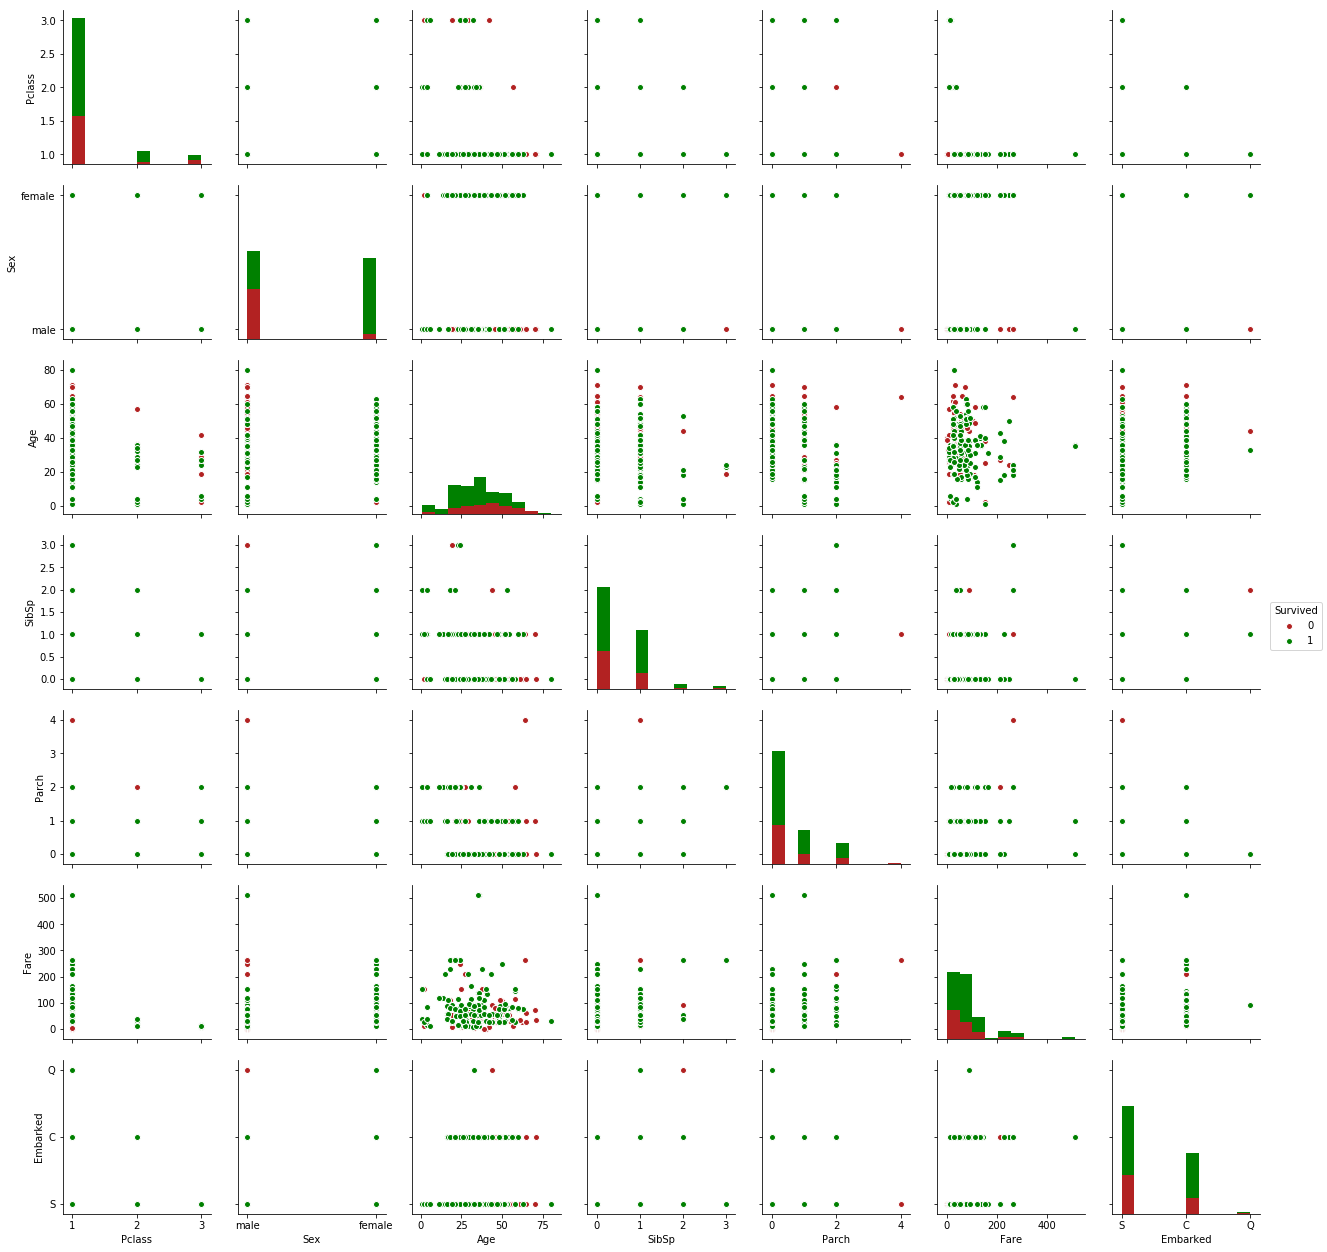

In [104]:
print('Raw data:')
sns.pairplot(train.dropna(axis=0),
             hue='Survived',
             palette=['firebrick', 'green'],
             vars=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'],
            );

In [105]:
train.index = train.PassengerId
train = train.drop(['Name', 'Ticket', 'Cabin'], axis=1)  # presumably not relevant

# encode categorical variables as integers:
train.Sex = train.Sex.map(lambda x: 1 if x == 'male' else 0)
train.Embarked = train.Embarked.map(lambda x: {'C': 1, 'Q':2, 'S':3}.get(x, 0))

# make 'Fare' a category from 0 to 9 (equal number data points per category):
train.Fare = pd.qcut(train.Fare, q=10, labels=False)

# combine number of siblings/spouse and number of partents/children into one feature: number of family members
train['Family'] = train.SibSp + train.Parch
train.Family = train.Family.map(lambda x: 3 if x >= 3 else x)  # make category '3 or more relatives'
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family
PassengerId,,,,,,,,,,
1,1,0,3,1,22.0,1,0,0,3,1
2,2,1,1,0,38.0,1,0,8,1,1
3,3,1,3,0,26.0,0,0,2,3,0
4,4,1,1,0,35.0,1,0,8,3,1
5,5,0,3,1,35.0,0,0,2,3,0


Processed data:


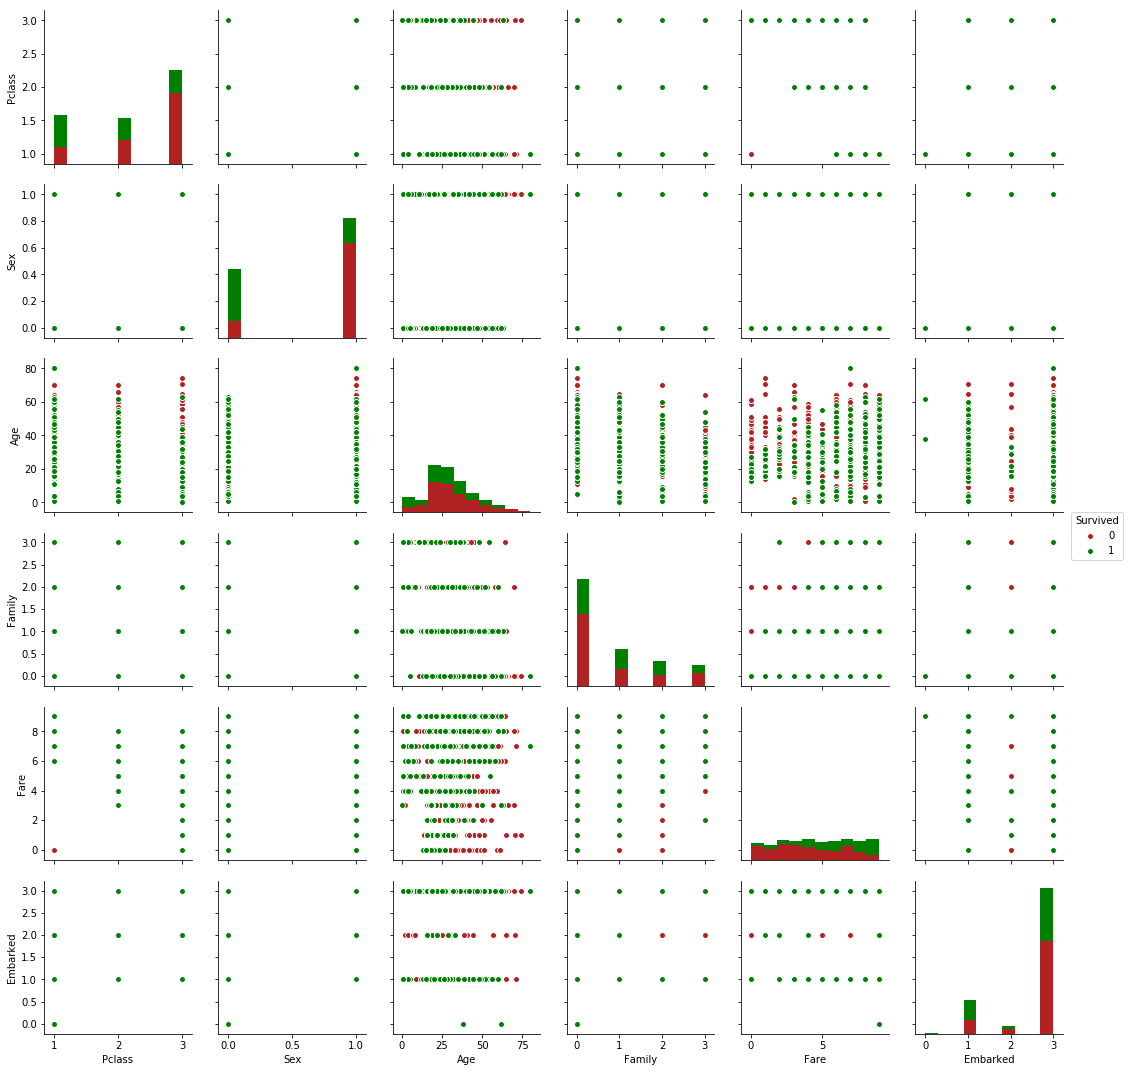

In [106]:
print('Processed data:')
sns.pairplot(train.dropna(axis=0),  # exclude missing values
             hue='Survived',
             palette=['firebrick', 'green'],
             vars=['Pclass', 'Sex', 'Age', 'Family', 'Fare', 'Embarked'],
            );

In [107]:
print('Missing values:')
train.isnull().sum()

Missing values:


PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
Family           0
dtype: int64

In [108]:
mean_age_per_group = train.groupby(['Sex', 'Family']).Age.mean().round().astype(int)
print('Mean age:\n{}'.format(mean_age_per_group))

Mean age:
Sex  Family
0    0         30
     1         30
     2         26
     3         21
1    0         33
     1         33
     2         26
     3         14
Name: Age, dtype: int64


In [109]:
guessed_age = train.apply(lambda x: mean_age_per_group[x.Sex, x.Family], axis=1)
print('Age guessed from mean age:\n{}'.format(guessed_age.head()))

Age guessed from mean age:
PassengerId
1    33
2    30
3    30
4    30
5    33
dtype: int64


In [110]:
# impute missing values:
train.Age = train.apply(lambda x: guessed_age[x.PassengerId] if np.isnan(x.Age) else x.Age, axis=1)
print('After impuation of missing age-values:\n{}\n'.format(train.isnull().sum()))

After impuation of missing age-values:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family         0
dtype: int64



In [111]:
train = train.drop(['SibSp', 'Parch', 'PassengerId'], axis=1, errors='ignore')  # note: index is PassengerId
print('processed training-set:')
train.head(10)

processed training-set:


,Survived,Pclass,Sex,Age,Fare,Embarked,Family
PassengerId,,,,,,,
1,0,3,1,22.0,0,3,1
2,1,1,0,38.0,8,1,1
3,1,3,0,26.0,2,3,0
4,1,1,0,35.0,8,3,1
5,0,3,1,35.0,2,3,0
6,0,3,1,33.0,3,2,0
7,0,1,1,54.0,8,3,0
8,0,3,1,2.0,5,3,3
9,1,3,0,27.0,4,3,2


In [118]:
X = np.array(train.drop('Survived', axis=1))
print(X)

[[ 3.  1. 22.  0.  3.  1.]
 [ 1.  0. 38.  8.  1.  1.]
 [ 3.  0. 26.  2.  3.  0.]
 ...
 [ 3.  0. 21.  6.  3.  3.]
 [ 1.  1. 26.  7.  1.  0.]
 [ 3.  1. 32.  1.  2.  0.]]


In [121]:
y = np.array(train.Survived)
print(y[:20])

[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1]
